## Unsupervised Clustering of U.S. Colleges with Engineering Programs using Data.gov College Scorecard API 

Clustering US colleges with engineering programs by admsission rate, costs (in-state tuition, out-of-state tuition, yearly attendance cost), tuition revenue, instructional expenditure, faculty salaries and full-time faculty rate, student demographics (average age at entry, percent male and female undergraduates), and debt information (median overall debt, median debt of completers only).

Data is from 2015, which is the most recent year for which all selected features were available from the API.

#### Not every school has all of this information available so clustering will be done in two ways:
- imputing missing values with fancyimpute then hierarchical clustering
- hierarchical clustering of schools with complete data then determine the clusters of the remaining schools with kNN classifier

#### Resulting cluster labels will be compared via:
- pairplots of critical features colored by cluster assignment
- silhouette score of selected features having no nulls


### Import libraries

In [123]:
import requests
import urllib3
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from fancyimpute import KNN 
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

### Data extraction from API

#### Set up API key, page information

In [4]:
API_key = 'dLYjvuCY07C3VHB8hHvK79hwshgrrCErHx4z2pi1'
per_page = '&_per_page=100'
page = '&_page='    ## will need 19 pages

#### Filter search for schools that predominantly award 4-year degrees and graduate degrees. The highest degree awarded must be at or above the graduate level

In [5]:
search_filter = 'school.degrees_awarded.predominant=3,4&school.degrees_awarded.highest=4' 

In [6]:
fields = ['school.name','school.city', 'school.state', '2015.student.size',  # these are just informational
         '2015.academics.program.bachelors.engineering',  ## for filtering of results
          'school.operating', ## for filtering, 
          'school.ownership',
          '2015.admissions.admission_rate.overall', 
         '2015.academics.program_percentage.engineering', 
          '2015.cost.attendance.academic_year', '2015.cost.tuition.in_state',
          '2015.cost.tuition.out_of_state' ,'school.tuition_revenue_per_fte',
          'school.instructional_expenditure_per_fte', 'school.faculty_salary',
          'school.ft_faculty_rate', 
          '2015.student.demographics.age_entry', '2015.student.demographics.female_share', 
          '2015.aid.median_debt_suppressed.overall', '2015.aid.median_debt_suppressed.completers.overall',
          '2015.student.demographics.men', '2015.student.demographics.women']

#### Prepare the url and grab the data from the API in 100-school chunks

In [7]:
search_fields = '&_fields='
for i in fields:
    search_fields = search_fields  + i + ','

In [8]:
list_results = []
for i in range(0,20):
    page_ = page + str(i)
    url = 'https://api.data.gov/ed/collegescorecard/v1/schools.json?'+ search_filter + search_fields +  \
        per_page + page_  + '&api_key=' + API_key
    res = requests.get(url)
    output = res.json()
    list_results.append(output['results'])

#### Filter for just the schools that have engineering programs

In [9]:
just_eng = []

for i in range(0, len(list_results)):
    for j in list_results[i]:
        if j['2015.academics.program.bachelors.engineering'] == 1:
            just_eng.append(j)  
        else:
            pass
print('There are ' + str(len(just_eng)) + ' engineering schools being included in this evaluation.')

There are 507 engineering schools being included in this evaluation.


#### Write the data to a file for later

In [8]:
with open("engineering_schools_Data.txt", 'w') as file:
    file.write(str(just_eng))   ## saving to file just in case

### Data cleaning and exploration

#### Filter for just open schools and set up a DataFrame

In [10]:
schools = pd.DataFrame(just_eng)
closed = schools['school.operating'] == 0
schools=schools.loc[~closed, :]   # removing closed school(s)

#### Remove extra content from column titles

In [11]:
columns = [x.strip('2015.') for x in schools.columns]
new_columns = []
for i in columns:
    for j in ['student.', 'school.', 'cost.', 'admissions.', 'aid.', 'repayment.', 'academics.']:
        if j in i:
            i = i.replace(j,'')
        else:
            pass
    new_columns.append(i)
col_dictionary = {}
for i in range(0, len(schools.columns)):
    col_dictionary[schools.columns[i]] = new_columns[i]
schools.rename(columns=col_dictionary, inplace=True)

#### Drop any columns that are all nulls, and the filtering columns

In [12]:
schools.dropna(axis = 1, how='all', inplace=True)
schools.drop(['operating', 'program.bachelors.engineering'], axis=1, inplace = True)

In [13]:
schools[['name', 'ownership']].head()

,name,ownership
0,Bob Jones University,3
1,DeVry University-Arizona,3
2,DeVry University-Texas,3
3,DeVry University-Virginia,3
4,University of California-Merced,1


#### Transform ownership column so that it is not imputed as a continuous variable

In [14]:
schools['ownership'] = schools['ownership'].map(lambda x: 'Public' if x == 1 else 'Private')

In [15]:
schools.columns[schools.dtypes == 'object']

Index(['city', 'name', 'ownership', 'state'], dtype='object')

#### Isolate numerial features for EDA & modeling

In [16]:
numerical_features = schools.columns[schools.dtypes != 'object']  
schools.columns[schools.dtypes == 'object']

Index(['city', 'name', 'ownership', 'state'], dtype='object')

#### Evaluate correlations

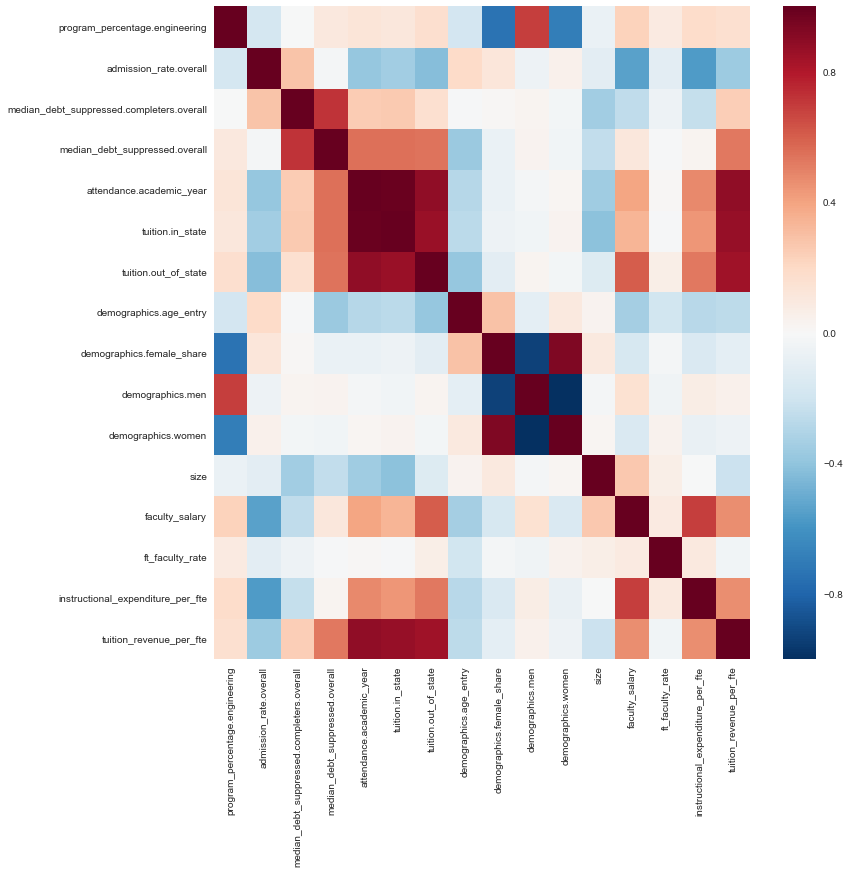

In [17]:
plt.figure(figsize=(12,12))
sns.heatmap(schools[numerical_features].corr())

Percent engineering programs is strongly negatively correlated with percent female undergraduate students and weakly negatively correlated with school size, age of entry, and admission rate.

Percent engineering programs is strong correlated with percent male undergraduate students and weakly correlated with tuition, faculty salaries, instructional expenditures, debt, and attendance.

#### Drop schools with 0% engineering for 2015

In [18]:
zero_eng = schools['program_percentage.engineering'] == 0
schools = schools.loc[~zero_eng, :]

### Option 1: Impute missing data for incomplete observations, then assign cluster labels 

#### Scale data

In [19]:
scaled_features = []
for i in numerical_features:
    j = 'scaled_'+str(i)
    schools[j] = (schools[i] - schools[i].mean())/schools[i].std()
    scaled_features.append(j)

#### Impute using fancyimpute KNN, assigning values based on three nearest neighbors

In [20]:
schools_imputed_array = KNN(k=2).complete(schools[scaled_features])

Imputing row 1/457 with 0 missing, elapsed time: 0.048
Imputing row 101/457 with 0 missing, elapsed time: 0.049
Imputing row 201/457 with 0 missing, elapsed time: 0.049
Imputing row 301/457 with 0 missing, elapsed time: 0.050
Imputing row 401/457 with 0 missing, elapsed time: 0.051


In [21]:
schools[scaled_features] = schools_imputed_array

#### Cluster with hierarchical clustering

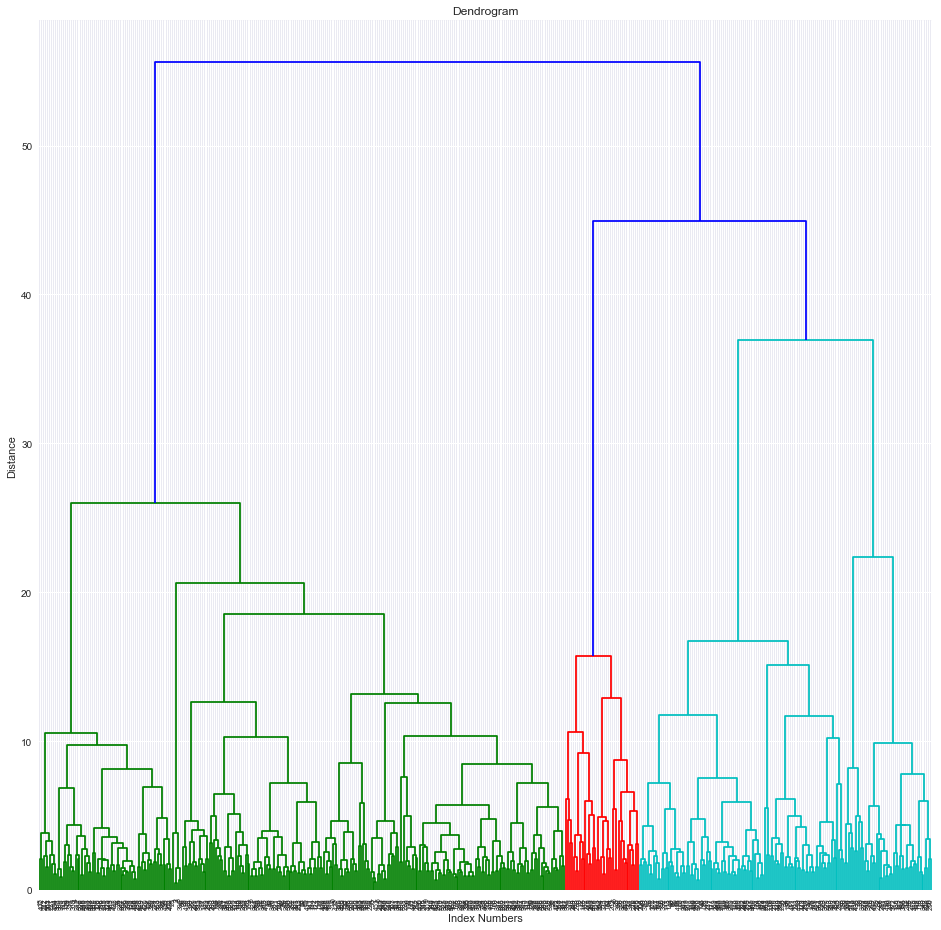

In [22]:
Z = linkage(schools[scaled_features], 'ward')
c, coph_dists = cophenet(Z, pdist(schools[scaled_features]))
plt.figure(figsize=(16,16))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=7.,
)
plt.show()

In [23]:
max_dist = 47
clusters = fcluster(Z, max_dist, criterion='distance')
schools['impute_first'] = clusters
schools['impute_first'].value_counts()

1    269
2    188
Name: impute_first, dtype: int64

#### Plot a few important variables to see how the clusters are separated

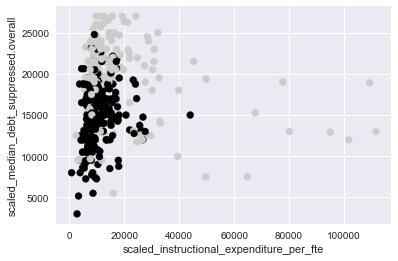

In [24]:
plt.scatter(schools['instructional_expenditure_per_fte'], 
            schools['median_debt_suppressed.overall'], c=clusters, cmap='nipy_spectral')
plt.xlabel('scaled_instructional_expenditure_per_fte')
plt.ylabel('scaled_median_debt_suppressed.overall')

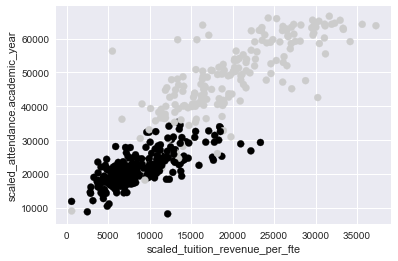

In [25]:
plt.scatter(schools['tuition_revenue_per_fte'], 
            schools['attendance.academic_year'], c=clusters, cmap='nipy_spectral')
plt.xlabel('scaled_tuition_revenue_per_fte')
plt.ylabel('scaled_attendance.academic_year')

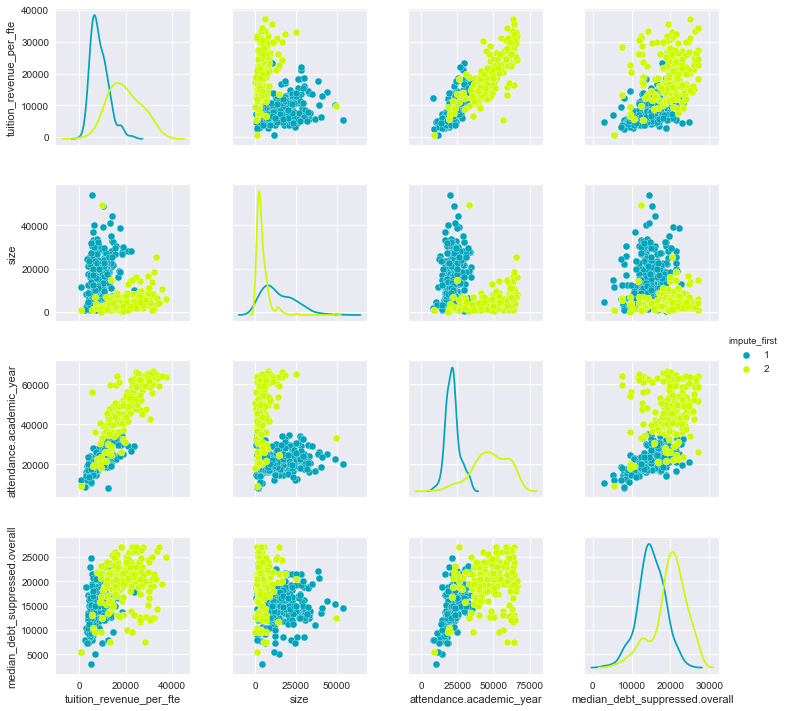

In [26]:
sns.pairplot(schools, diag_kind = 'kde',  
        hue='impute_first', palette='nipy_spectral', vars=['tuition_revenue_per_fte', 
       'size','attendance.academic_year', 'median_debt_suppressed.overall'])

#### Calculate silhouette score

In [27]:
data = schools[scaled_features]
labels = schools['impute_first']
silhouette_score(data, labels)

0.25244823406514538

The silhouette score can be calculated for option 1 because all nulls have been imputed, cannot calculate this score with all features for option 2 because nulls will not be filled. 

### Option 2: Cluster schools with all information included, then predict clusters for schools which are missing information

In [28]:
schools_full_info = schools.dropna(axis=0, how='any')
schools_full_info.shape

(437, 37)

#### Use the scaled data

In [29]:
scaled_features = ['scaled_admission_rate.overall',
       'scaled_median_debt_suppressed.completers.overall',
       'scaled_median_debt_suppressed.overall',
       'scaled_attendance.academic_year', 'scaled_tuition.in_state',
       'scaled_tuition.out_of_state', 'scaled_demographics.age_entry',
       'scaled_demographics.female_share', 'scaled_demographics.men',
       'scaled_demographics.women', 'scaled_size', 'scaled_faculty_salary',
       'scaled_ft_faculty_rate', 'scaled_instructional_expenditure_per_fte',
       'scaled_tuition_revenue_per_fte']

#### Hierarchical clustering

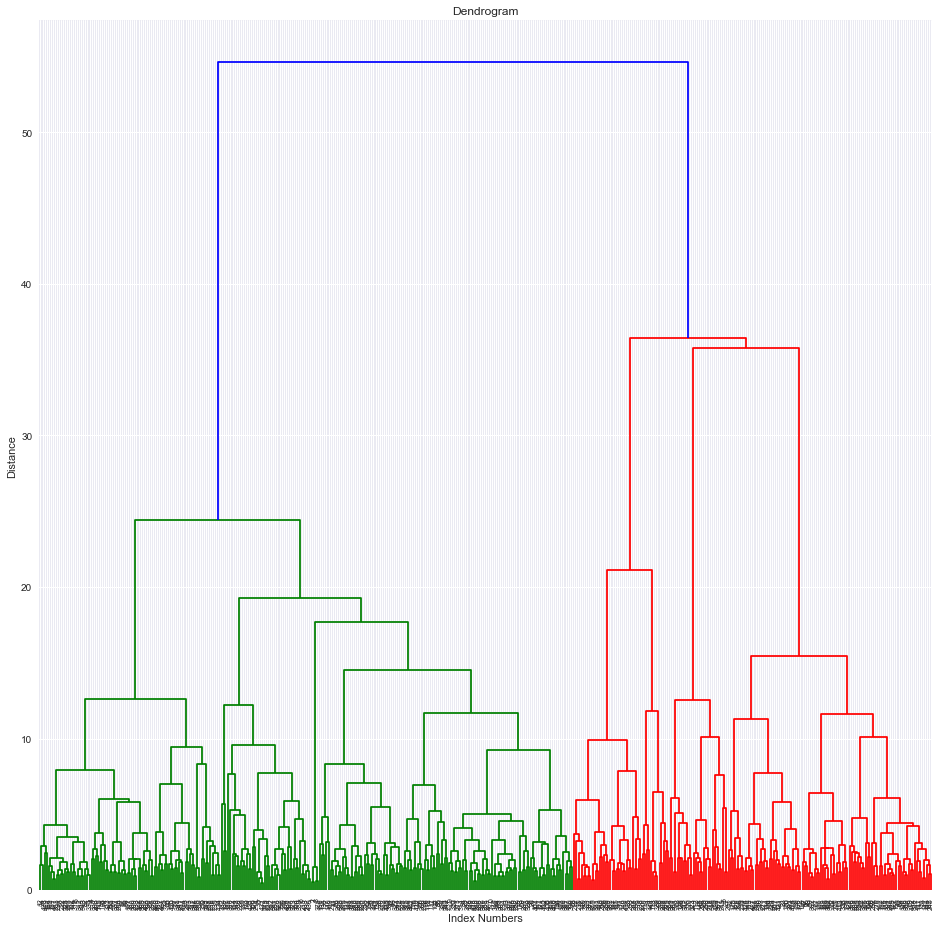

In [30]:
Zf = linkage(schools_full_info[scaled_features], 'ward')
c, coph_dists = cophenet(Zf, pdist(schools_full_info[numerical_features]))
plt.figure(figsize=(16,16))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Zf,
    leaf_rotation=90.,  
    leaf_font_size=7.,
)
plt.show()

In [124]:
max_dist = 40
clusters = fcluster(Zf, max_dist, criterion='distance')
schools_full_info['clusters'] = clusters
schools_full_info['clusters'].value_counts()

1    261
2    176
Name: clusters, dtype: int64

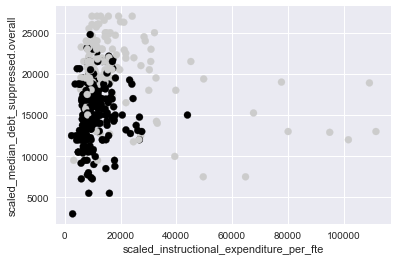

In [32]:
plt.scatter(schools_full_info['instructional_expenditure_per_fte'], 
            schools_full_info['median_debt_suppressed.overall'], c=clusters, cmap='nipy_spectral')
plt.xlabel('scaled_instructional_expenditure_per_fte')
plt.ylabel('scaled_median_debt_suppressed.overall')

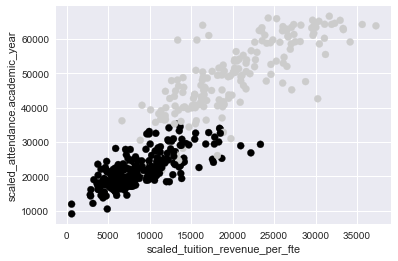

In [33]:
plt.scatter(schools_full_info['tuition_revenue_per_fte'], 
            schools_full_info['attendance.academic_year'], c=clusters, cmap='nipy_spectral')
plt.xlabel('scaled_tuition_revenue_per_fte')
plt.ylabel('scaled_attendance.academic_year')

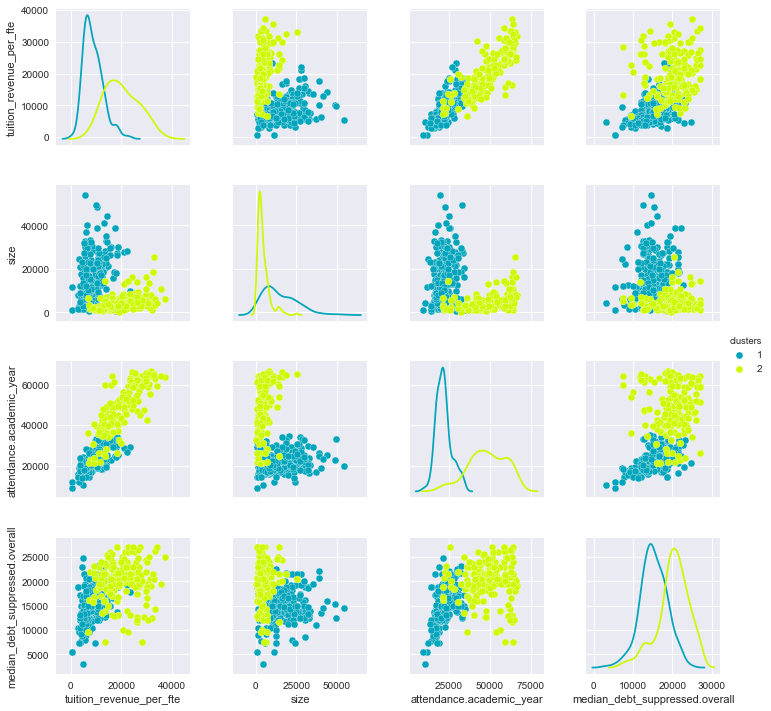

In [34]:
sns.pairplot(schools_full_info, diag_kind = 'kde',  
        hue='clusters', palette='nipy_spectral', vars=['tuition_revenue_per_fte', 
       'size','attendance.academic_year', 'median_debt_suppressed.overall'])

#### Get inputs ready for cluster-predicting model

In [35]:
# get a DataFrame with just the rows that have null values in at least one column
names_full_schools = schools_full_info['name']
need_predictions = schools['name'].isin(names_full_schools)
pre_df = schools.loc[~need_predictions, :]

In [40]:
# these are the features (minus the info-only columns) that can be used for cluster predictions
for i in list(pre_df.columns[pre_df.isnull().sum() == 0]):
    print(i)

program_percentage.engineering
median_debt_suppressed.overall
tuition.in_state
tuition.out_of_state
demographics.age_entry
demographics.men
demographics.women
size
city
faculty_salary
instructional_expenditure_per_fte
name
ownership
state
tuition_revenue_per_fte
scaled_program_percentage.engineering
scaled_admission_rate.overall
scaled_median_debt_suppressed.completers.overall
scaled_median_debt_suppressed.overall
scaled_attendance.academic_year
scaled_tuition.in_state
scaled_tuition.out_of_state
scaled_demographics.age_entry
scaled_demographics.female_share
scaled_demographics.men
scaled_demographics.women
scaled_size
scaled_faculty_salary
scaled_ft_faculty_rate
scaled_instructional_expenditure_per_fte
scaled_tuition_revenue_per_fte
impute_first


In [41]:
# input features for knn model, as a list
input_features = [ 'scaled_program_percentage.engineering',
       'scaled_median_debt_suppressed.overall', 'scaled_tuition.in_state',
       'scaled_tuition.out_of_state', 'scaled_demographics.age_entry',
       'scaled_demographics.men', 'scaled_demographics.women', 'scaled_size',
       'scaled_faculty_salary', 'scaled_instructional_expenditure_per_fte',
       'scaled_tuition_revenue_per_fte']

In [42]:
# the scaled inputs to predict missing clusters
final_X = pre_df[input_features]

#### Scale and split known data

In [43]:
y = schools_full_info['clusters']
X = schools_full_info[input_features]

In [44]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size = 0.5, stratify=y)

#### Evaluate Kneighbors classifier with split data

In [45]:
def scorer(estimator, X, y):
#     print(estimator.get_params(deep=False)['n_neighbors'], 
#           np.mean(cross_val_score(estimator, X, y)), np.mean(cross_val_score(estimator,Xte, yte)))
    return np.mean(cross_val_score(estimator, X, y))

In [48]:
knnc = KNeighborsClassifier(weights='distance')
param_dict= {'n_neighbors':list(range(1,8))}
gs = GridSearchCV(knnc, param_dict, scoring=scorer)
gs.fit(Xtr, ytr)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x1244b5950>, verbose=0)

#### Predict missing clusters with Kneighbors classifier

In [125]:
knnF = KNeighborsClassifier(n_neighbors = 2, weights='distance')
knnc.fit(X,y)
pre_df['clusters'] = knnc.predict(final_X)

#### Compile all schools with assigned cluster labels into a new DataFrame

In [50]:
final = schools_full_info.append(pre_df)

In [51]:
final['clusters'].value_counts()

1    275
2    182
Name: clusters, dtype: int64

In [52]:
report = pd.merge(schools, final[['name', 'clusters']], how='outer', on='name')

In [53]:
report.rename(columns = {'clusters':'model_clusters'}, inplace=True)

#### Evalute option 2 clusters via pairplots

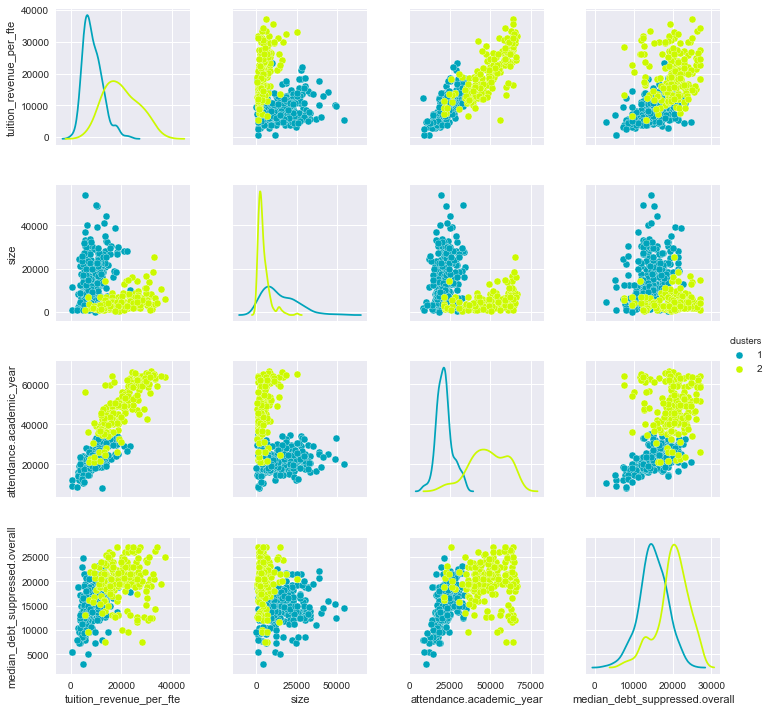

In [54]:
sns.pairplot(final, diag_kind = 'kde',  
        hue='clusters', palette='nipy_spectral', vars=['tuition_revenue_per_fte', 
       'size','attendance.academic_year', 'median_debt_suppressed.overall'])
plt.savefig('clusters.png')

### Compare results of both clustering options

#### Visually compare separation of clusters with pairplots of un-scaled data

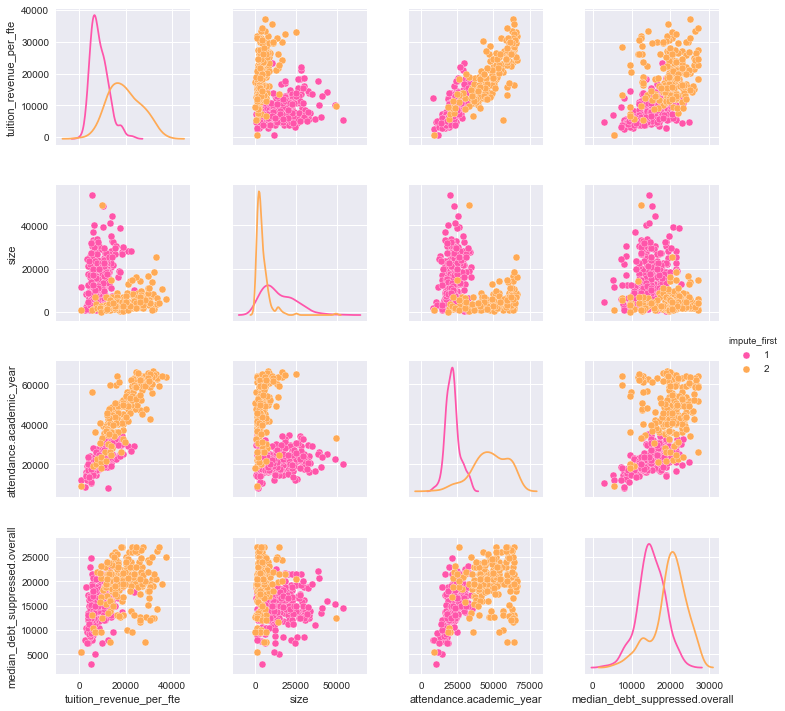

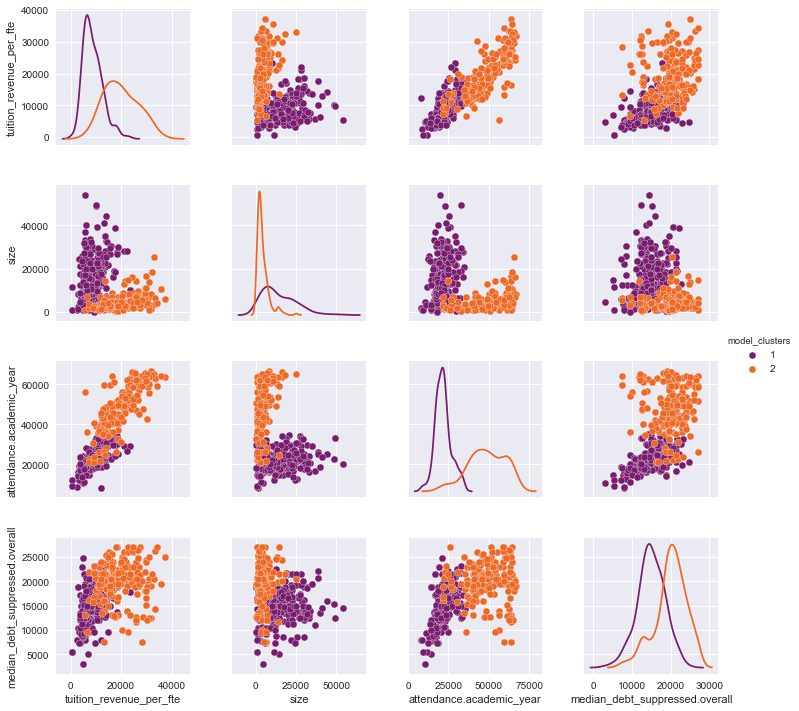

In [55]:
fig = plt.figure()
fig.set_size_inches(18, h=15)
ax1 = sns.pairplot(report, diag_kind = 'kde',  
        hue='impute_first', palette='spring', vars=['tuition_revenue_per_fte', 
       'size','attendance.academic_year', 'median_debt_suppressed.overall'])
ax2 = sns.pairplot(report, diag_kind = 'kde',  
        hue='model_clusters', palette='inferno', vars=['tuition_revenue_per_fte', 
       'size','attendance.academic_year', 'median_debt_suppressed.overall'])

#### Evaluate the differences in cluster assignments

In [136]:
matches = report['impute_first'] == report['model_clusters']
matches.value_counts()

True     449
False      8
dtype: int64

#### Calculate percent of incomplete observations which where assigned to the same cluster via both methods

In [142]:
null_assignment_score = (matches.value_counts()[0]) /(schools.shape[0] - schools_full_info.shape[0])
print(1- null_assignment_score)  ## just over half, not ideal

0.6


#### Visualize the observations which were assigned to different clusters by the two options

In [143]:
switch_names = report.loc[~matches, 'name']

In [144]:
for i in range(0, report.shape[0]):
    report['switch'] = report['model_clusters']
    
for i in switch_names.index:
    report['switch'][i] = 0

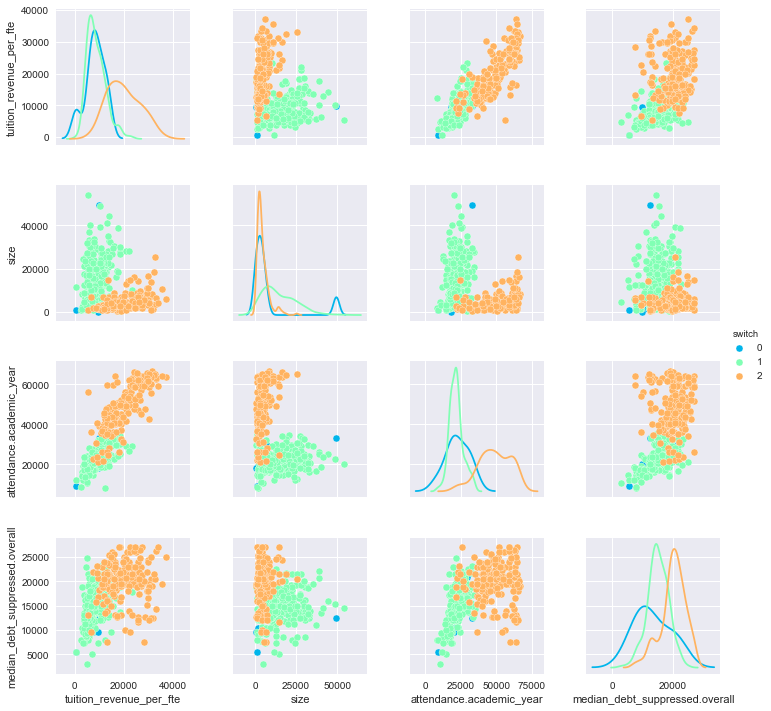

In [61]:
fig = plt.figure()
fig.set_size_inches(18, h=15)
ax1 = sns.pairplot(report, diag_kind = 'kde',  
        hue='switch', palette='rainbow', vars=['tuition_revenue_per_fte', 
       'size','attendance.academic_year', 'median_debt_suppressed.overall'])

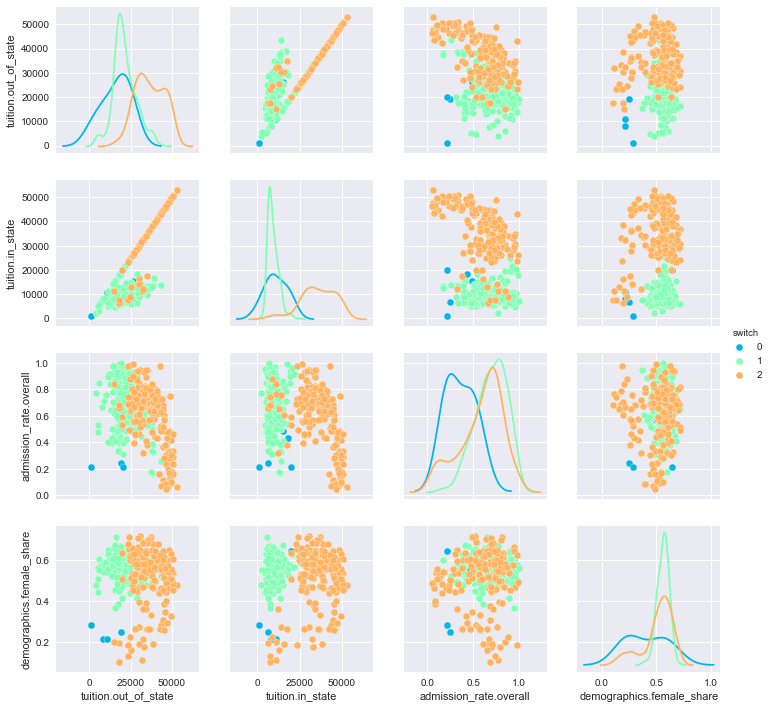

In [62]:
fig = plt.figure()
fig.set_size_inches(18, h=15)
ax1 = sns.pairplot(report, diag_kind = 'kde',  
        hue='switch', palette='rainbow', vars=['tuition.out_of_state', 
       'tuition.in_state','admission_rate.overall', 'demographics.female_share'])

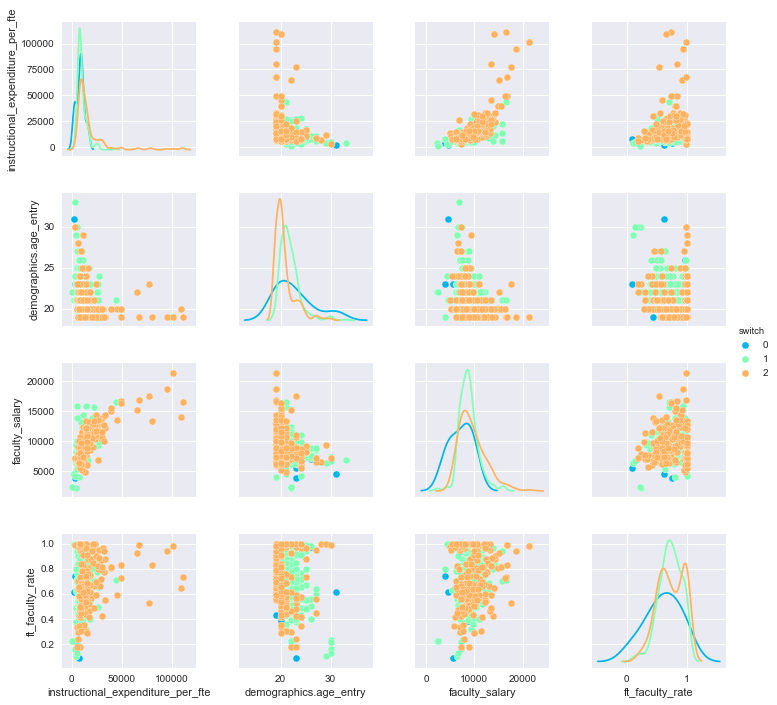

In [65]:
fig = plt.figure()
fig.set_size_inches(18, h=15)
ax1 = sns.pairplot(report, diag_kind = 'kde',  
        hue='switch', palette='rainbow', vars=['instructional_expenditure_per_fte', 
       'demographics.age_entry','faculty_salary', 'ft_faculty_rate'])

Looking at the above three pairplots, the following features seem to be the most important in the clustering assignment:
- in and out-of-state tuition
- tuition revenue
- size
- cost of attendance
- median debt 

#### Calculate silhouette scores for both clustering options with only these features, exluding any nulls. 
- The scores will be similar since the cluster label assignments are so similar. I am assuming the few mis-matched clusters are due to less important features
- Calculation of silhouette score is possible here because there are few nulls in these columns and these can be dropped before comparison. 

In [105]:
important_features = ['tuition.out_of_state', 
    'tuition.in_state', 'attendance.academic_year',
    'tuition_revenue_per_fte', 'size', 
    'median_debt_suppressed.overall', 'impute_first',
    'model_clusters']

In [106]:
scoring_report = report[important_features].dropna()
scoring_report.shape, report[important_features].shape

((456, 8), (457, 8))

In [108]:
data= scoring_report
labels_opt1 = scoring_report['impute_first']
labels_opt2 = scoring_report['model_clusters']
print('Option 1: ' + str(silhouette_score(data, labels_opt1)))
print('Option 2: '+ str(silhouette_score(data, labels_opt1)))

Option 1: 0.511208650513
Option 2: 0.511208650513


#### Check: Are these clusters better than labeling by ownership (public or private)? 
- Ownership status data has also been taken from API

In [127]:
important_features_plus = ['tuition.out_of_state', 
       'tuition.in_state', 'attendance.academic_year',
        'tuition_revenue_per_fte', 'size', 
                      'median_debt_suppressed.overall', 'impute_first',
                      'model_clusters', 'ownership']

In [128]:
scoring_report = report[important_features_plus].dropna()
scoring_report.shape, report[important_features_plus].shape

((456, 9), (457, 9))

In [129]:
scoring_report['ownership']=scoring_report['ownership'].map(lambda x: 0 if x == 'Public' else 1)

In [130]:
data= scoring_report
labels_own = scoring_report['ownership']
print('Ownership : ' + str(silhouette_score(data, labels_own)))

Ownership : 0.506235860731


The clusters are marginally better than just clustering by ownership. It would probably have been better to simply assign clusters by ownership because that has real-world meaning. As shown in paiplots below, the ownership clusters look very similar to artificially-generated clusters.

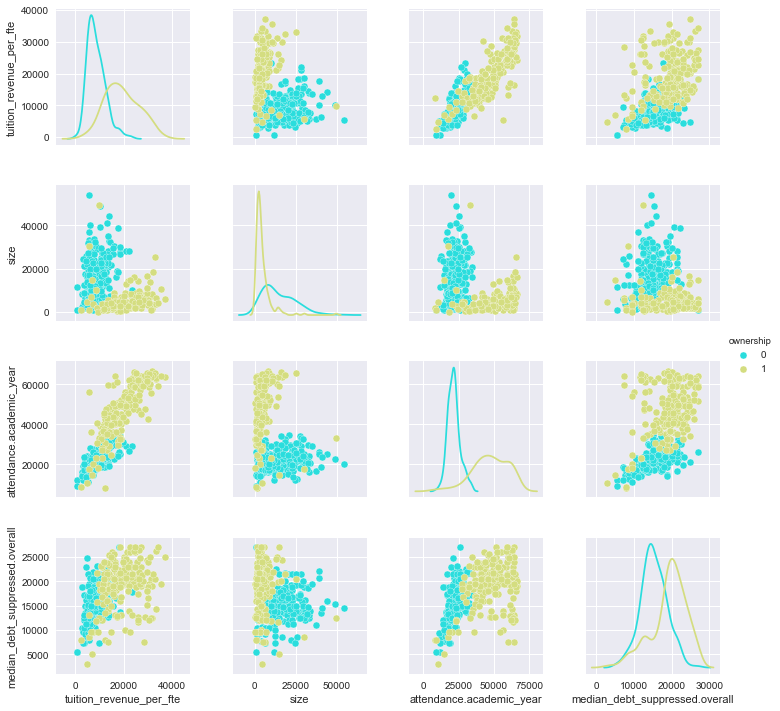

In [131]:
fig = plt.figure()
fig.set_size_inches(18, h=15)
ax1 = sns.pairplot(scoring_report, diag_kind = 'kde',  
        hue='ownership', palette='rainbow', vars=['tuition_revenue_per_fte', 
       'size','attendance.academic_year', 'median_debt_suppressed.overall'])

### Final Notes

#### 1. Results will vary depending on whether nulls are imputed before clustering or cluster labels are assigned for incompletes after intial labels are assigned

#### 2. The number of nulls in the data to be clustered matters.
- In this case, there were relatively few (8) out of hundreds of data points that may have gone one way or the other based on the clustering scheme

#### 3. Cluster labels which have intrinsic meaning are better than artifical cluster labels, even if such artificial clusters can show slightly better separation between clusters